In [20]:
# Download train and val dataset
!wget -q -O report_train.npy "https://www.dropbox.com/scl/fi/30dlbblp7wytcvoy05col/report_train.npy?rlkey=jx100qoz5n1d654v2mi32i9aj&dl=1"
!wget -q -O report_val.npy "https://www.dropbox.com/scl/fi/oo6g1yqhbjm22wffeddgv/report_val.npy?rlkey=9rqe0rucjhrbzv3x7xbs5047z&dl=1"

## A. Data Loading and Preprocessing

In [21]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [22]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
from torchvision import transforms

# Load Dataset
x_train = np.transpose(np.load('report_train.npy'), (0, 3, 1, 2))
x_val = np.transpose(np.load('report_val.npy'), (0, 3, 1, 2))

print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_val: {x_val.shape}')

num_classes = 6

# Create labels
y_train = np.concatenate([np.full(425, i) for i in range(num_classes)])
y_val = np.concatenate([np.full(100, i) for i in range(num_classes)])

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()

x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).long()

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),  # Converts tensor to PIL Image
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CustomDataset(x_train, y_train, transform=transform)
val_dataset = CustomDataset(x_val, y_val, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


Shape of x_train: (2550, 3, 150, 150)
Shape of x_val: (600, 3, 150, 150)


In [1]:
# Known dataset shapes
shape_of_x_train = (2550, 3, 150, 150)
shape_of_x_val = (600, 3, 150, 150)

# Total number of images in each set
num_train_images = shape_of_x_train[0]
num_val_images = shape_of_x_val[0]

# Assuming a balanced dataset for simplicity
num_classes = 6
images_per_class_train = num_train_images // num_classes
images_per_class_val = num_val_images // num_classes

print(f"The dataset for training contains a total of {num_train_images} images, "
      f"with each of the {num_classes} classes ('Tumor', 'Stroma', 'Complex', "
      f"'Lympho', 'Debris', 'Mucosa') having approximately {images_per_class_train} images.")

print(f"The validation dataset contains a total of {num_val_images} images, "
      f"with each class having approximately {images_per_class_val} images.")


The dataset for training contains a total of 2550 images, with each of the 6 classes ('Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa') having approximately 425 images.
The validation dataset contains a total of 600 images, with each class having approximately 100 images.


In [23]:
# Grab a single batch from the DataLoader
sample_batch = next(iter(train_loader))
print(f"Sample batch type: {type(sample_batch)}")
print(f"Sample batch length: {len(sample_batch)}")
if len(sample_batch) == 2:
    images, labels = sample_batch
    print(f"Transformed Images shape: {images.shape}, Labels shape: {labels.shape}")
else:
    print("Batch does not have the expected format of (images, labels)")


Sample batch type: <class 'list'>
Sample batch length: 2
Transformed Images shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32])


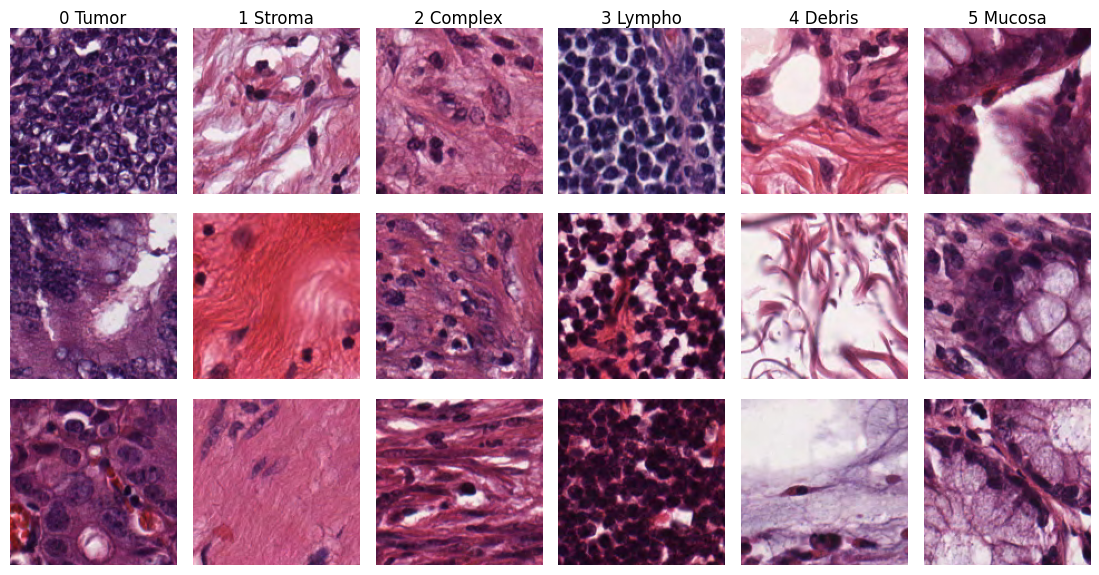

In [24]:
import matplotlib.pyplot as plt
import random

class_names = ['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa']

num_classes = 6
samples_per_class = 3

fig, axes = plt.subplots(samples_per_class, num_classes, figsize=(12, 6))

plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.1, hspace=0.1)

for class_idx in range(num_classes):
    indices_of_class = np.where(y_train == class_idx)[0]
    random_indices = random.sample(list(indices_of_class), samples_per_class)

    for i in range(samples_per_class):
        ax = axes[i, class_idx]
        img = x_train[random_indices[i]].numpy().transpose((1, 2, 0))
        img = img / img.max()
        ax.imshow(img)
        ax.axis('off')

        if i == 0:
            ax.set_title(f'{class_idx} {class_names[class_idx]}', pad=3)

plt.show()

## B. Defining Neural Networks

In [25]:
import torch

if torch.cuda.is_available():
    print("CUDA is available. GPU: ", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available.")

CUDA is available. GPU:  Tesla T4


In [40]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

#Load a Pre-trained CNN Model
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# Load a pre-trained ResNet model
model = models.resnet18(pretrained=True)

# Modify the final fully connected layer
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.3),  # Adding dropout with a 50% probability
    nn.Linear(num_features, num_classes)
)
#model.fc = nn.Linear(num_features, num_classes)  # 6 classes

model = model.cuda()

#Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
#optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## C. Training the Neural Network

In [41]:
# Training Loop
num_epochs = 30  # Define the number of epochs

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []


for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    train_correct = 0
    total_train = 0

    for images, labels in train_loader:
        images = images.cuda()
        labels = labels.cuda()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate acuuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    scheduler.step()

    train_accuracy = (train_correct / total_train) * 100
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation Loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            labels = labels.cuda()

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate Accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = (val_correct / total_val) * 100
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    #print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%')



#Saving the model
torch.save(model.state_dict(), 'cancer_histology_cnn_model.pth')

Epoch [1/30], Train Loss: 0.6921, Train Accuracy: 75.25%, Val Loss: 0.4287, Val Accuracy: 85.50%
Epoch [2/30], Train Loss: 0.4650, Train Accuracy: 82.75%, Val Loss: 0.8803, Val Accuracy: 67.17%
Epoch [3/30], Train Loss: 0.3616, Train Accuracy: 87.57%, Val Loss: 0.7027, Val Accuracy: 75.83%
Epoch [4/30], Train Loss: 0.3219, Train Accuracy: 89.57%, Val Loss: 3.2183, Val Accuracy: 52.50%
Epoch [5/30], Train Loss: 0.2966, Train Accuracy: 89.57%, Val Loss: 0.3215, Val Accuracy: 88.67%
Epoch [6/30], Train Loss: 0.2420, Train Accuracy: 91.53%, Val Loss: 0.7140, Val Accuracy: 80.17%
Epoch [7/30], Train Loss: 0.2370, Train Accuracy: 92.00%, Val Loss: 0.5435, Val Accuracy: 81.50%
Epoch [8/30], Train Loss: 0.1250, Train Accuracy: 95.29%, Val Loss: 0.2045, Val Accuracy: 91.83%
Epoch [9/30], Train Loss: 0.0754, Train Accuracy: 97.57%, Val Loss: 0.1777, Val Accuracy: 93.17%
Epoch [10/30], Train Loss: 0.0538, Train Accuracy: 98.51%, Val Loss: 0.2066, Val Accuracy: 93.17%
Epoch [11/30], Train Loss: 0.

##Visualize Model Performance

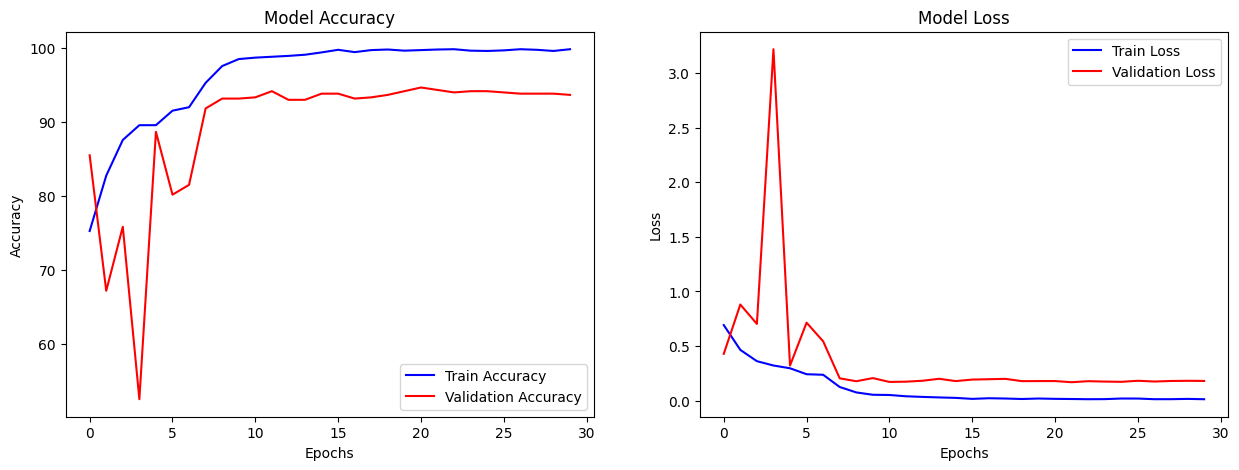

In [42]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies, 'b-', label='Train Accuracy')
ax[0].plot(val_accuracies, 'r-', label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='lower right')

# Plotting training and validation loss
ax[1].plot(train_losses, 'b-', label='Train Loss')
ax[1].plot(val_losses, 'r-', label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='upper right')

plt.show()

# **D. Evaluating Your Trained Model**

### Process Test Dataset

In [43]:
# Download test dataset,
!wget -q -O report_test.npy "https://www.dropbox.com/scl/fi/ufcagx2cvjmervgqrgwrt/report_test.npy?rlkey=fijueom5x54628ivpzeki2bt0&dl=1"

In [44]:
x_test = np.transpose(np.load('report_test.npy'), (0, 3, 1, 2))
print(f'Shape of x_test: {x_test.shape}')

y_test = np.concatenate([np.full(100, i) for i in range(num_classes)])

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).long()

print(f'x_test: max value is {x_test.max().item()}, min value is {x_test.min().item()}, data type is {x_test.dtype}.')

batch_size = 32

# Define the same transformations you used for the training data
transform = transforms.Compose([
    transforms.ToPILImage(),  # since the images are in tensor format
    transforms.Resize((224, 224)),  # Resize images as required by the model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
])

# Create the test dataset using the CustomDataset class
test_dataset = CustomDataset(x_test, y_test, transform=transform)

# Create a DataLoader for the test set
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Shape of x_test: (600, 3, 150, 150)
x_test: max value is 255.0, min value is 0.0, data type is torch.float32.


### Load Trained Model and Evaluate

In [ ]:
model = models.resnet18(pretrained=False)  # Initialize with pretrained=False since we're loading our own weights
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),  # Maintain the dropout layer
    nn.Linear(num_features, num_classes)  # Match the number of output classes
)
#model.fc = nn.Linear(num_features, num_classes)  # Adjust the final layer as per your number of classes

# Load the saved model state
model.load_state_dict(torch.load('cancer_histology_cnn_model.pth'))

# Move the model to the GPU if available
model = model.cuda()

model.eval()  # Set the model to evaluation mode


In [46]:
test_loss = 0.0
test_correct = 0
total_test = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = (test_correct / total_test) * 100
print(f'Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%')


Test Loss: 0.1842, Test Accuracy: 94.67%
